# New Term Topics Methods and Document Coloring

In [1]:
from gensim.corpora import Dictionary
from gensim.models import ldamodel
import numpy
%matplotlib inline


We're setting up our corpus now. We want to show off the new `get_term_topics` and `get_document_topics` functionalities, and a good way to do so is to play around with words which might have different meanings in different context.

The word `bank` is a good candidate here, where it can mean either the financial institution or a river bank.
In the toy corpus presented, there are 11 documents, 5 `river` related and 6 `finance` related. 

In [2]:
texts = [['bank','river','shore','water'],
        ['river','water','flow','fast','tree'],
        ['bank','water','fall','flow'],
        ['bank','bank','water','rain','river'],
        ['river','water','mud','tree'],
        ['money','transaction','bank','finance'],
        ['bank','borrow','money'], 
        ['bank','finance'],
        ['finance','money','sell','bank'],
        ['borrow','sell'],
        ['bank','loan','sell']]

dictionary = Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

We set up the LDA model in the corpus. We set the number of topics to be 2, and expect to see one which is to do with river banks, and one to do with financial banks. 

In [3]:
numpy.random.seed(1) # setting random seed to get the same results each time.
model = ldamodel.LdaModel(corpus, id2word=dictionary, num_topics=2)

In [4]:
model.show_topics()

[(0,
  u'0.164*bank + 0.142*water + 0.108*river + 0.076*flow + 0.067*borrow + 0.063*sell + 0.060*tree + 0.048*money + 0.046*fast + 0.044*rain'),
 (1,
  u'0.196*bank + 0.120*finance + 0.100*money + 0.082*sell + 0.067*river + 0.065*water + 0.056*transaction + 0.049*loan + 0.046*tree + 0.040*mud')]

And like we expected, the LDA model has given us near perfect results. Bank is the most influential word in both the topics, as we can see. The other words help define what kind of bank we are talking about. Let's now see where our new methods fit in.

### get_term_topics

The function `get_term_topics` returns the odds of that particular word belonging to a particular topic. 
A few examples:

In [5]:
model.get_term_topics('water')

[(0, 0.12821234071249407), (1, 0.047247458568794552)]

Makes sense, the value for it belonging to `topic_0` is a lot more.

In [6]:
model.get_term_topics('finance')

[(0, 0.017179349495865623), (1, 0.10331511184214646)]

This also works out well, the word finance is more likely to be in topic_1 to do with financial banks.

In [7]:
model.get_term_topics('bank')

[(0, 0.15042435080542083), (1, 0.1804462723220118)]

And this is particularly interesting. Since the word bank is likely to be in both the topics, the values returned are also very similar.

### get_document_topics and Document Word-Topic Coloring

`get_document_topics` is an already existing gensim functionality which uses the `inference` function to get the sufficient statistics and figure out the topic distribution of the document.

The addition to this is the ability for us to now know the topic distribution for each word in the document. 
Let us test this with two different documents which have the word bank in it, one in the finance context and one in the river context.

The `get_document_topics` method returns (along with the standard document topic proprtion) the word_type followed by a list sorted with the most likely topic ids, when `per_word_topics` is set as true.

In [8]:
bow_water = ['bank','water','bank']
bow_finance = ['bank','finance','bank']

In [9]:
bow = model.id2word.doc2bow(bow_water) # convert to bag of words format first
doc_topics, word_topics, phi_values = model.get_document_topics(bow, per_word_topics=True)

word_topics

[(0, [0, 1]), (3, [0, 1])]

Now what does that output mean? It means that like `word_type 1`, our `word_type` `3`, which is the word `bank`, is more likely to be in `topic_0` than `topic_1`.

You must have noticed that while we unpacked into `doc_topics` and `word_topics`, there is another variable - `phi_values`. Like the name suggests, phi_values contains the phi values for each topic for that particular word, scaled by feature length. Phi is essentially the probability of that word in that document belonging to a particular topic. The next few lines should illustrate this. 

In [10]:
phi_values

[(0, [(0, 0.9248645556429429), (1, 0.075135444357057019)]),
 (3, [(0, 1.5817120973072436), (1, 0.41828790269275634)])]

This means that `word_type` 0 has the following phi_values for each of the topics. 
What is intresting to note is `word_type` 3 - because it has 2 occurences (i.e, the word `bank` appears twice in the bow), we can see that the scaling by feature length is very evident. The sum of the phi_values is 2, and not 1.

Now that we know exactly what `get_document_topics` does, let us now do the same with our second document, `bow_finance`.

In [11]:
bow = model.id2word.doc2bow(bow_finance) # convert to bag of words format first
doc_topics, word_topics, phi_values = model.get_document_topics(bow, per_word_topics=True)

word_topics

[(3, [1, 0]), (12, [1, 0])]

And lo and behold, because the word bank is now used in the financial context, it immedietly swaps to being more likely associated with `topic_1`.

We've seen quite clearly that based on the context, the most likely topic associated with a word can change. 
This differs from our previous method, `get_term_topics`, where it is a 'static' topic distribution. 

It must also be noted that because the gensim implementation of LDA uses Variational Bayes sampling, a `word_type` in a document is only given one topic distribution. For example, the sentence 'the bank by the river bank' is likely to be assigned to `topic_0`, and each of the bank word instances have the same distribution.

## Coloring topic-terms

These methods can come in handy when we want to color the words in a corpus or a document. If we wish to color the words in a corpus (i.e, color all the words in the dictionary of the corpus), then `get_term_topics` would be a better choice. If not, `get_document_topics` would do the trick.

We'll now attempt to color these words and plot it using `matplotlib`. 
This is just one way to go about plotting words - there are more and better ways.

[WordCloud](https://github.com/amueller/word_cloud) is such a python package which also does this.

For our simple illustration, let's keep `topic_0` as red, and `topic_1` as blue.

In [12]:
# this is a sample method to color words. Like mentioned before, there are many ways to do this.

def color_words(model, doc):
    import matplotlib.pyplot as plt
    import matplotlib.patches as patches
    
    # make into bag of words
    doc = model.id2word.doc2bow(doc)
    # get word_topics
    doc_topics, word_topics, phi_values = model.get_document_topics(doc, per_word_topics=True)

    # color-topic matching
    topic_colors = { 0:'red', 1:'blue'}
    
    # set up fig to plot
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])

    # a sort of hack to make sure the words are well spaced out.
    word_pos = 1/len(doc)
    
    # use matplotlib to plot words
    for word, topics in word_topics:
        ax.text(word_pos, 0.8, model.id2word[word],
                horizontalalignment='center',
                verticalalignment='center',
                fontsize=20, color=topic_colors[topics[0]],  # choose just the most likely topic
                transform=ax.transAxes)
        word_pos += 0.2 # to move the word for the next iter

    ax.set_axis_off()
    plt.show()


Let us revisit our old examples to show some examples of document coloring

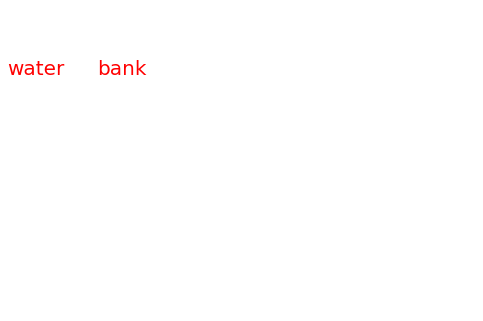

In [13]:
# our river bank document

bow_water = ['bank','water','bank']
color_words(model, bow_water)

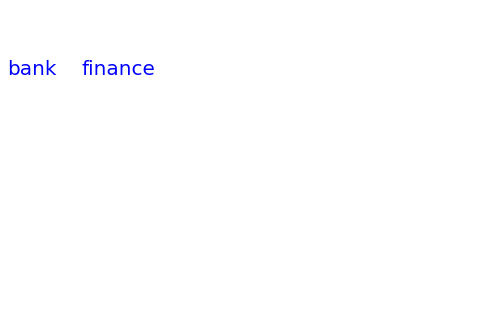

In [14]:
bow_finance = ['bank','finance','bank']
color_words(model, bow_finance)

What is fun to note here is that while bank was colored red in our first example, it is now blue because of the financial context - something which the numbers proved to us before.

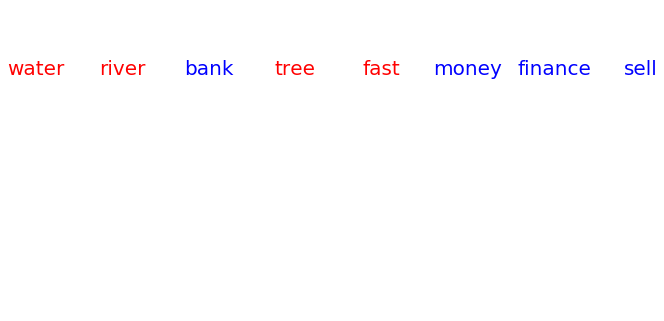

In [15]:
# sample doc with a somewhat even distribution of words among the likely topics

doc = ['bank', 'water', 'bank', 'finance', 'money','sell','river','fast','tree']
color_words(model, doc)


We see that the document word coloring is done just the way we expected. :)

We can do the same for the entire vocabulary, statically. The only difference would be in using `get_term_topics`, and iterating over the dictionary.